In [1]:
import os
import torch
from accelerate import Accelerator

from llama2_Model import  llama2_7b_Model_peft
from pep_Dataloader import pep_Dataloader
from evaluation import get_accuracy, get_precision_recall

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [20]:
from evaluation import get_accuracy, get_precision_recall

In [2]:
! nvidia-smi

Sun Jan 21 14:09:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.01              Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0              12W /  80W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Get model and dataloader

In [3]:
def get_filepath(name,classnum_name,file_name):
    '''
    param name: name of the dataset, pep-3k or pap
    param classnum_name: for pap dataset, binary or multiclass
    param file_name: dev, test, train
    return: the str of apath of the file
    '''
    current_dir =os.path.realpath(".")
    parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
    parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
    parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
    if name=='pap':
        filepath=os.path.abspath(os.path.join(parent_dir,'Data',name,'train-dev-test-split-filtered',classnum_name,file_name+'.csv'))
    else:
        filepath=os.path.abspath(os.path.join(parent_dir,'Data',name,'train-dev-test-split',classnum_name,file_name+'.csv'))
    print(filepath)
    return filepath


In [4]:
# Model from Hugging Face hub
base_model= "meta-llama/Llama-2-7b-hf"

filepath1=get_filepath('pep-3k','','train')
filepath2=get_filepath('pep-3k','','dev')
filepath3=get_filepath('pep-3k','','test')


/home/linux1/BOX/modeling23/Data/pep-3k/train-dev-test-split/train.csv
/home/linux1/BOX/modeling23/Data/pep-3k/train-dev-test-split/dev.csv
/home/linux1/BOX/modeling23/Data/pep-3k/train-dev-test-split/test.csv


In [5]:
# from transformers import AutoTokenizer, AutoModelForCausalLM     

# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf") 
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")  
llama_model = llama2_7b_Model_peft(base_model)
tokenizer = llama_model.tokenizer

Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.10s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original number of parameters: 6607351808
LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (p

In [6]:
train_dataloader_object=pep_Dataloader(filepath1,tokenizer,3)
eval_dataloader_object=pep_Dataloader(filepath2,tokenizer,'defalut')
test_dataloader_object=pep_Dataloader(filepath3,tokenizer,'defalut')

Generating train split: 2448 examples [00:00, 103459.75 examples/s]
Map: 100%|██████████| 2448/2448 [00:00<00:00, 38453.05 examples/s]


In [7]:
print("train_dataloader_object:",train_dataloader_object.dataset)

train_dataloader_object: Dataset({
    features: ['label', 'text'],
    num_rows: 2448
})


In [9]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch.nn as nn
from transformers import get_scheduler

optimizer = AdamW(llama_model.model.parameters(), lr=1e-4 )#5e-5)
loss_fn = nn.CrossEntropyLoss()

accelerator = Accelerator()
train_dataloader, eval_dataloader,test_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader_object.dataloader, eval_dataloader_object.dataloader, test_dataloader_object.dataloader , llama_model.model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader_object.dataset)

#learning rate adjustment:
lr_scheduler = get_scheduler( 
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Check original model with test data

In [21]:
def do_inference(dataloader):
    model.eval()
    with torch.no_grad():
        for labels,text in dataloader:
            logits = model(**text).logits
            the_labels=labels
            get_accuracy(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag='false',flag2='print')

In [11]:
do_inference(test_dataloader)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.472
true_positives: 4
false_positives: 13
false_negatives: 149
true_negatives: 141
---positive is plausible
Precision: 0.235
Recall: 0.026
F-score: 0.047
true_positives: 4
false_positives: 13
false_negatives: 149
true_negatives: 141
---positive is implausible
Precision: 0.486
Recall: 0.916
F-score: 0.635


### Train

In [12]:
loss_list=[]
accuracy_list=[]
loss_sum=0
accuracy_sum=0

In [13]:
print(num_epochs)
print(len(train_dataloader))
num_training_steps = num_epochs * len(train_dataloader)
print(num_training_steps)
print(num_training_steps/20)
# print(int(num_training_steps/30))
for thelabels,text in train_dataloader:
    print('thelabels:',thelabels)
    print('text:',text)
    break

3
816
2448
122.4
thelabels: tensor([0, 0, 1], device='cuda:0')
text: {'input_ids': tensor([[    1,  4552,   561,   424,   528,  1296, 25158,     2,     2,     2],
        [    1,  6114,   330,  6472,  8805,     2,     2,     2,     2,     2],
        [    1,  7679,  2181,  1878,  3800,     2,     2,     2,     2,     2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], device='cuda:0')}


In [ ]:
# train
progress_bar = tqdm(range(int(num_training_steps/20)))

flag=0
for epoch in range(num_epochs):
    for thelabels,text in train_dataloader:
        model.train()
        outputs = model(**text)
        logits = outputs.logits
        print('logits:',logits)
        print('thelabels:',thelabels)
        loss = loss_fn(logits.squeeze(), thelabels)
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        flag+=1

        loss_sum += int(loss.item())
        a=get_accuracy(logits, thelabels)
        accuracy_sum+=a

        if flag%20==0:
            print(flag,'loss:,',loss_sum/flag, 'accuarcy:',accuracy_sum/flag)
            loss_list.append(loss_sum/flag)
            accuracy_list.append(accuracy_sum/flag)
            progress_bar.update(1)

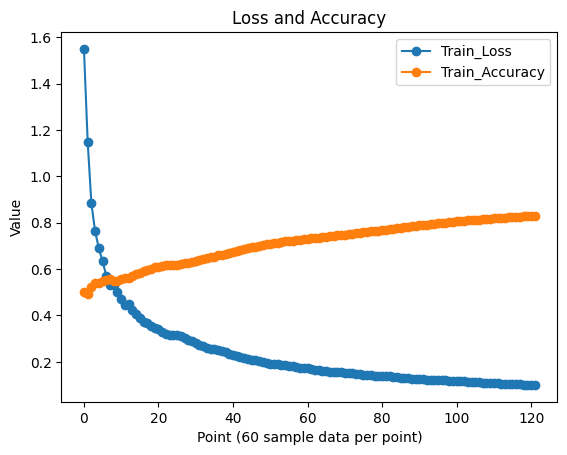

In [15]:
# print(loss_list)
# print(accuracy_list)

import matplotlib.pyplot as plt

# Plotting the data
plt.plot(loss_list, label='Train_Loss', marker='o')
plt.plot(accuracy_list, label='Train_Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Point (60 sample data per point)')
plt.ylabel('Value')
plt.title('Loss and Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [22]:
do_inference(test_dataloader)

Accuracy: 0.863
true_positives: 140
false_positives: 29
false_negatives: 13
true_negatives: 125
---positive is plausible
Precision: 0.828
Recall: 0.915
F-score: 0.870
true_positives: 140
false_positives: 29
false_negatives: 13
true_negatives: 125
---positive is implausible
Precision: 0.906
Recall: 0.812
F-score: 0.856


In [23]:
do_inference(eval_dataloader)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.824
true_positives: 129
false_positives: 30
false_negatives: 24
true_negatives: 123
---positive is plausible
Precision: 0.811
Recall: 0.843
F-score: 0.827
true_positives: 129
false_positives: 30
false_negatives: 24
true_negatives: 123
---positive is implausible
Precision: 0.837
Recall: 0.804
F-score: 0.820


In [ ]:
# save_dir= "./after_finetuned_llama2_7B_un_merge"
# model.save_pretrained(save_dir,safe_safetensors=True)
# save_dir_tokenizer= save_dir+"/tokenizer"
# tokenizer.save_pretrained(save_dir_tokenizer)

In [18]:
#model.merge_and_unload()

##  Problem: Loading the model after saving will encounter problems:
### 1. save model before using model.merge_and_unload() : 
#### Reload success. But after saving and loading the model, the performance is not the same (almost as bad as the original model).
### 2. save model after using model.merge_and_unload(): 
#### Reload fail. Get error: SafetensorError: Error while deserializing header: InvalidHeaderDeserialization

This problem has not been solved yet.